
# Harmonic spectrum

This notebook demonstrates how to extract the harmonic spectrum from an audio signal.
The basic idea is to estimate the fundamental frequency (f0) at each time step,
and extract the energy at integer multiples of f0 (the *harmonics*).
This representation can be used to represent the short-term evolution of timbre,
either for resynthesis [1]_ or downstream analysis [2]_.

.. [1] Bonada, Jordi, X. Serra, X. Amatriain, and A. Loscos.
    "Spectral processing."
    DAFX Digital Audio Effects (2011): 393-444.

.. [2] Rafii, Zafar.
    "The Constant-Q Harmonic Coefficients: A timbre feature designed for music signals."
    IEEE Signal Processing Magazine 39, no. 3 (2022): 90-96.


In [ ]:
# Code source: Brian McFee
# License: ISC

We'll need numpy and matplotlib as usual



In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For synthesis, we'll use mir_eval's sonify module
import mir_eval.sonify

# For audio playback, we'll use IPython.display's Audio widget
from IPython.display import Audio

import librosa

We'll start by loading a speech example to analyze



In [2]:
y, sr = librosa.load(librosa.ex('libri2'), duration=5)

Audio(data=y, rate=sr)

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Next, we'll estimate the fundamental frequency (f0)
of the voice using `librosa.pyin`.

We'll constrain `f0` to lie within the range 50 Hz
to 300 Hz.

pyin returns three arrays:
  - `f0`, the sequence of fundamental frequency estimates
  - `voicing`, the sequence of indicator variables for whether
    a fundamental was detected or not at each time step
  - `voicing_probability`, the sequence of probabilities that each
    time step contains a fundamental frequency

For this application, we'll only be using `f0`.  Note that by default,
pyin will set `f0[n] = np.nan` (not a number) whenever `voicing[n] == False`.
We'll handle this situation later on when resynthesizing the signal.



In [4]:
f0, voicing, voicing_probability = librosa.pyin(y=y, sr=sr, fmin=50, fmax=300)

We can visualize the f0 contour on top of a spectrogram as follows



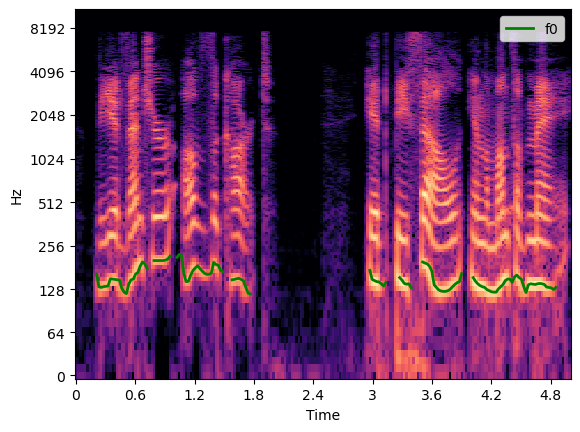

In [7]:
S = np.abs(librosa.stft(y))

times = librosa.times_like(S, sr=sr)

fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(times, f0, linewidth=2, color='green', label='f0')
ax.legend()

The figure above illustrates how the f0 contour tends to
follow the lowest frequency with the most energy, which
are indicated by bright colors toward the bottom of the
image.  The patterns replicate at higher frequencies
corresponding to harmonics of the fundamental, which are
identified by `2*f0`, `3*f0`, `4*f0`, etc.

We can use `librosa.f0_harmonics` to extract the energy
from a specified set of harmonics relative to the f0.



In [8]:
# Let's use the first 30 harmonics: 1, 2, 3, ..., 30
harmonics = np.arange(1, 31)

# And standard Fourier transform frequencies
frequencies = librosa.fft_frequencies(sr=sr)

harmonic_energy = librosa.f0_harmonics(S, f0=f0, harmonics=harmonics, freqs=frequencies)

We can visualize the result `harmonic_energy` alongside the
full spectrogram `S` to see how they compare to each other.



[Text(0, 0.5, 'Harmonics')]

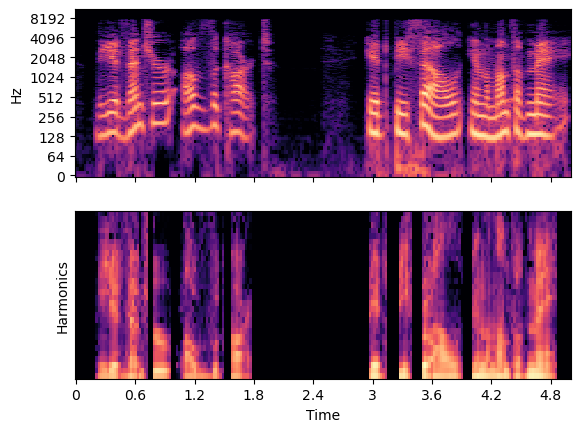

In [11]:
# sphinx_gallery_thumbnail_number = 2

fig, ax = plt.subplots(nrows=2, sharex=True)

librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
librosa.display.specshow(librosa.amplitude_to_db(harmonic_energy, ref=np.max),
                         x_axis='time', ax=ax[1])
ax[0].label_outer()
ax[1].set(ylabel='Harmonics')

In the above figure, we can observe the same general
patterns of spectral energy as in the full spectrogram,
but notice that the shapes no longer move up and down
with the f0 contour.  The resulting `harmonic_energy`
has been normalized with regard to the fundamental.




From the f0 contour and the harmonic energy measurements,
we can reconstruct an approximation to the original signal
by sinusoidal modeling.  This really just means adding up
sine waves at the chosen set of frequencies and scaled
appropriately by the amount of energy at that frequency
over time.

Since the f0 contour is a time-varying frequency measurement,
the synthesis will need to support variable frequencies.
Luckily, the `mir_eval.sonify` module does exactly this.
We'll generate a separate signal for each harmonic separately,
and add them into a mixture to better approximate the original
signal.



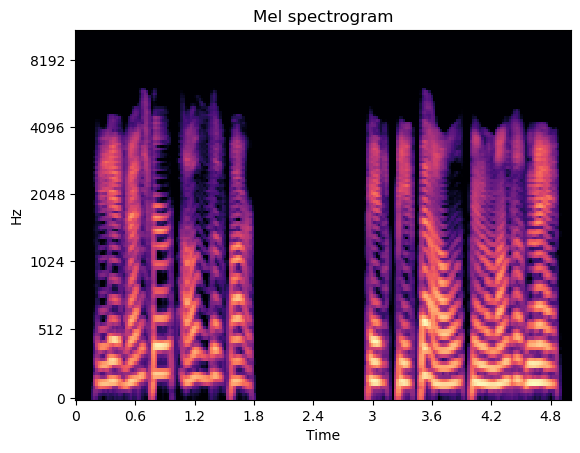

In [14]:
# f0 takes value np.nan for unvoiced regions, but this isn't
# helpful for synthesis.  We'll use `np.nan_to_num` to replace
# nans with a frequency of 0.
f0_synth = np.nan_to_num(f0)

y_out = np.zeros_like(y)

for i, (factor, energy) in enumerate(zip(harmonics, harmonic_energy)):
    # Mix in a synthesized pitch contour
    y_out = y_out + mir_eval.sonify.pitch_contour(times, f0_synth * factor,
                                                amplitudes=energy,
                                                fs=sr,
                                                length=len(y))

fig, ax = plt.subplots()
melspec = librosa.power_to_db(librosa.feature.melspectrogram(y=y_out, sr=sr), ref=np.max)
librosa.display.specshow(melspec, y_axis='mel', x_axis='time', ax=ax)
ax.set(title='Mel spectrogram')
Audio(data=y_out, rate=sr)

The synthesized audio is not a perfect reconstruction
of the input signal.  Notably, it is derived from a
sparse sinusoidal modeling assumption, and will
therefore not do well at representing transients.
The result is still largely intelligible, however,
and the decoupling of f0 from harmonic energy allows
us to modify the synthesized signal in various ways.

For example, we can synthesize the same utterance
with a constant f0 to produce a monotone effect.



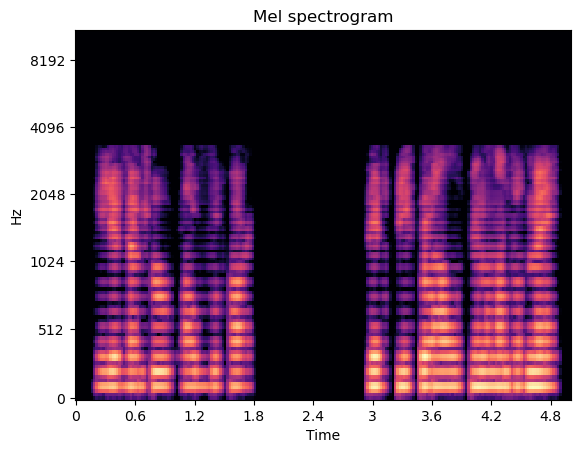

In [21]:
# Make a fake f0 contour
f_mono = 110 * np.ones_like(f0)

ymono = np.zeros_like(y)

for i, (factor, energy) in enumerate(zip(harmonics, harmonic_energy)):
    # Use f_mono here instead of f0
    ymono = ymono + mir_eval.sonify.pitch_contour(times, f_mono * factor,
                                                amplitudes=energy,
                                                fs=sr,
                                                length=len(y))

fig, ax = plt.subplots()
melspec = librosa.power_to_db(librosa.feature.melspectrogram(y=ymono, sr=sr), ref=np.max)
librosa.display.specshow(melspec, y_axis='mel', x_axis='time', ax=ax)
ax.set(title='Mel spectrogram')
Audio(data=ymono, rate=sr)